# Logistic Regression with Approximate Gradient Descent Optimization

This notebook implements a logistic regression model using approximate gradient descent optimization to predict League of Legends game outcomes based on early game features (10-15 minutes).

## Features Used (24 total):
- **Objective Control**: firstblood, firstdragon, firstherald, firstbaron, firsttower, firstmidtower, firsttothreetowers
- **Economic Advantages**: golddiffat10, golddiffat15, xpdiffat10, xpdiffat15, csdiffat10, csdiffat15  
- **Combat Statistics**: killsat10, killsat15, assistsat10, assistsat15, opp_killsat10, opp_killsat15, opp_assistsat10, opp_assistsat15
- **Target**: result (1 = win, 0 = lose)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

In [19]:
ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"
SOURCE_DIR = DATA_DIR / "source"
OUTPUT_DIR = DATA_DIR / "output"

In [2]:
def load_and_preprocess_data():
    """
    Load LoL esports data and preprocess for logistic regression
    """
    # List of CSV files to load
    years = range(2014, 2025)
    data_frames = []

    for year in years:
        try:
            file_path = (
                f"../data/source/{year}_LoL_esports_match_data_from_OraclesElixir.csv"
            )
            df = pd.read_csv(file_path)
            data_frames.append(df)
            print(f"Loaded {year} data: {df.shape[0]} rows")
        except FileNotFoundError:
            print(f"File for {year} not found, skipping...")
            continue

    # Combine all data
    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        print(
            f"Total combined data: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns"
        )
        return combined_df
    else:
        print("No data files found!")
        return None


def prepare_features(df):
    """
    Extract and prepare the 24 features for logistic regression
    """
    # Define the 24 features we want to use
    feature_columns = [
        # Objective Control (7 features)
        "firstblood",
        "firstdragon",
        "firstherald",
        "firstbaron",
        "firsttower",
        "firstmidtower",
        "firsttothreetowers",
        # Economic Advantages (6 features)
        "golddiffat10",
        "golddiffat15",
        "xpdiffat10",
        "xpdiffat15",
        "csdiffat10",
        "csdiffat15",
        # Combat Statistics (11 features)
        "killsat10",
        "killsat15",
        "assistsat10",
        "assistsat15",
        "opp_killsat10",
        "opp_killsat15",
        "opp_assistsat10",
        "opp_assistsat15",
    ]

    # Check which features are available in the dataset
    available_features = [col for col in feature_columns if col in df.columns]
    missing_features = [col for col in feature_columns if col not in df.columns]

    print(f"Available features: {len(available_features)}")
    print(f"Missing features: {missing_features}")

    # Filter data to only include rows with complete feature data
    df_filtered = df[available_features + ["result"]].dropna()

    # Convert binary features to proper 0/1 encoding
    binary_features = [
        "firstblood",
        "firstdragon",
        "firstherald",
        "firstbaron",
        "firsttower",
        "firstmidtower",
        "firsttothreetowers",
    ]

    for feature in binary_features:
        if feature in df_filtered.columns:
            df_filtered[feature] = df_filtered[feature].astype(int)

    print(f"Filtered data shape: {df_filtered.shape}")

    return df_filtered[available_features], df_filtered["result"], available_features


# Load the data
print("Loading LoL esports data...")
raw_data = load_and_preprocess_data()

Loading LoL esports data...
Loaded 2014 data: 11016 rows
Loaded 2015 data: 21792 rows
Loaded 2015 data: 21792 rows
Loaded 2016 data: 50568 rows
Loaded 2016 data: 50568 rows
Loaded 2017 data: 68424 rows
Loaded 2017 data: 68424 rows
Loaded 2018 data: 80904 rows
Loaded 2018 data: 80904 rows
Loaded 2019 data: 97524 rows
Loaded 2019 data: 97524 rows
Loaded 2020 data: 117552 rows
Loaded 2020 data: 117552 rows
Loaded 2021 data: 148596 rows
Loaded 2021 data: 148596 rows
Loaded 2022 data: 150588 rows
Loaded 2022 data: 150588 rows
Loaded 2023 data: 132120 rows
Loaded 2023 data: 132120 rows
Loaded 2024 data: 117648 rows
Loaded 2024 data: 117648 rows
Total combined data: 996732 rows, 164 columns
Total combined data: 996732 rows, 164 columns


In [3]:
class ApproximateGradientDescentLogisticRegression:
    """
    Logistic Regression with Approximate Gradient Descent Optimization

    This implementation uses approximate gradient descent where we compute
    gradients using finite differences or stochastic approximations.
    """

    def __init__(
        self,
        learning_rate=0.01,
        max_iterations=1000,
        tolerance=1e-6,
        approximation_method="finite_diff",
        epsilon=1e-8,
        batch_size=None,
    ):
        """
        Initialize the logistic regression model

        Args:
            learning_rate: Step size for gradient descent
            max_iterations: Maximum number of iterations
            tolerance: Convergence tolerance
            approximation_method: 'finite_diff', 'stochastic', or 'momentum'
            epsilon: Small value for finite difference approximation
            batch_size: Batch size for stochastic methods (None = full batch)
        """
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.approximation_method = approximation_method
        self.epsilon = epsilon
        self.batch_size = batch_size

        # Model parameters
        self.weights = None
        self.bias = None

        # Training history
        self.cost_history = []
        self.iteration_history = []

    def sigmoid(self, z):
        """Sigmoid activation function with numerical stability"""
        # Clip z to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def cost_function(self, X, y, weights, bias):
        """Compute logistic regression cost function"""
        m = X.shape[0]
        z = X.dot(weights) + bias
        predictions = self.sigmoid(z)

        # Add small epsilon to prevent log(0)
        predictions = np.clip(predictions, self.epsilon, 1 - self.epsilon)

        cost = -(1 / m) * np.sum(
            y * np.log(predictions) + (1 - y) * np.log(1 - predictions)
        )
        return cost

    def compute_exact_gradient(self, X, y, weights, bias):
        """Compute exact gradient for comparison"""
        m = X.shape[0]
        z = X.dot(weights) + bias
        predictions = self.sigmoid(z)

        dw = (1 / m) * X.T.dot(predictions - y)
        db = (1 / m) * np.sum(predictions - y)

        return dw, db

    def approximate_gradient_finite_diff(self, X, y, weights, bias):
        """Approximate gradient using finite differences"""
        dw = np.zeros_like(weights)

        # Approximate gradient for weights
        for i in range(len(weights)):
            weights_plus = weights.copy()
            weights_minus = weights.copy()
            weights_plus[i] += self.epsilon
            weights_minus[i] -= self.epsilon

            cost_plus = self.cost_function(X, y, weights_plus, bias)
            cost_minus = self.cost_function(X, y, weights_minus, bias)

            dw[i] = (cost_plus - cost_minus) / (2 * self.epsilon)

        # Approximate gradient for bias
        cost_plus = self.cost_function(X, y, weights, bias + self.epsilon)
        cost_minus = self.cost_function(X, y, weights, bias - self.epsilon)
        db = (cost_plus - cost_minus) / (2 * self.epsilon)

        return dw, db

    def approximate_gradient_stochastic(self, X, y, weights, bias):
        """Approximate gradient using stochastic sampling"""
        m = X.shape[0]

        if self.batch_size is None:
            batch_size = min(32, m)  # Default batch size
        else:
            batch_size = min(self.batch_size, m)

        # Randomly sample a batch
        indices = np.random.choice(m, batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]

        # Compute gradient on the batch
        return self.compute_exact_gradient(X_batch, y_batch, weights, bias)

    def approximate_gradient_momentum(
        self, X, y, weights, bias, momentum_dw=None, momentum_db=None, beta=0.9
    ):
        """Approximate gradient using momentum-based optimization"""
        # Compute current gradient (using stochastic if specified)
        if self.batch_size:
            dw, db = self.approximate_gradient_stochastic(X, y, weights, bias)
        else:
            dw, db = self.compute_exact_gradient(X, y, weights, bias)

        # Initialize momentum if first iteration
        if momentum_dw is None:
            momentum_dw = np.zeros_like(dw)
            momentum_db = 0

        # Update momentum
        momentum_dw = beta * momentum_dw + (1 - beta) * dw
        momentum_db = beta * momentum_db + (1 - beta) * db

        return momentum_dw, momentum_db, momentum_dw, momentum_db

    def fit(self, X, y):
        """Fit the logistic regression model using approximate gradient descent"""
        m, n = X.shape

        # Initialize parameters
        self.weights = np.random.normal(0, 0.01, n)
        self.bias = 0

        # Initialize momentum if using momentum method
        momentum_dw = None
        momentum_db = None

        print(f"Training with {self.approximation_method} approximation...")
        print(f"Dataset shape: {X.shape}")

        for i in range(self.max_iterations):
            # Compute current cost
            current_cost = self.cost_function(X, y, self.weights, self.bias)
            self.cost_history.append(current_cost)
            self.iteration_history.append(i)

            # Compute approximate gradients based on method
            if self.approximation_method == "finite_diff":
                dw, db = self.approximate_gradient_finite_diff(
                    X, y, self.weights, self.bias
                )
            elif self.approximation_method == "stochastic":
                dw, db = self.approximate_gradient_stochastic(
                    X, y, self.weights, self.bias
                )
            elif self.approximation_method == "momentum":
                dw, db, momentum_dw, momentum_db = self.approximate_gradient_momentum(
                    X, y, self.weights, self.bias, momentum_dw, momentum_db
                )
            else:
                # Default to exact gradient
                dw, db = self.compute_exact_gradient(X, y, self.weights, self.bias)

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Check for convergence
            if (
                i > 0
                and abs(self.cost_history[-1] - self.cost_history[-2]) < self.tolerance
            ):
                print(f"Converged after {i + 1} iterations")
                break

            if i % 100 == 0:
                print(f"Iteration {i}: Cost = {current_cost:.6f}")

        print(f"Final cost: {self.cost_history[-1]:.6f}")
        return self

    def predict_proba(self, X):
        """Predict class probabilities"""
        z = X.dot(self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        """Make binary predictions"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

    def score(self, X, y):
        """Calculate accuracy score"""
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def plot_cost_history(self):
        """Plot the cost function over iterations"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.iteration_history, self.cost_history, "b-", linewidth=2)
        plt.title(
            f"Cost Function Over Iterations ({self.approximation_method.title()} Method)"
        )
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.grid(True, alpha=0.3)
        plt.show()

In [4]:
# Prepare the data if it was loaded successfully
if raw_data is not None:
    print("Preparing features...")
    X, y, feature_names = prepare_features(raw_data)

    print(f"\nFeature summary:")
    print(f"Number of features: {len(feature_names)}")
    print(f"Feature names: {feature_names}")
    print(f"Dataset shape: {X.shape}")
    print(f"Target distribution:")
    print(y.value_counts())

    # Check for missing values
    print(f"\nMissing values in features: {X.isnull().sum().sum()}")
    print(f"Missing values in target: {y.isnull().sum()}")

    # Display basic statistics
    print(f"\nFeature statistics:")
    print(X.describe())
else:
    print("No data available for processing")

Preparing features...
Available features: 21
Missing features: []
Filtered data shape: (140536, 22)

Feature summary:
Number of features: 21
Feature names: ['firstblood', 'firstdragon', 'firstherald', 'firstbaron', 'firsttower', 'firstmidtower', 'firsttothreetowers', 'golddiffat10', 'golddiffat15', 'xpdiffat10', 'xpdiffat15', 'csdiffat10', 'csdiffat15', 'killsat10', 'killsat15', 'assistsat10', 'assistsat15', 'opp_killsat10', 'opp_killsat15', 'opp_assistsat10', 'opp_assistsat15']
Dataset shape: (140536, 21)
Target distribution:
result
0    70268
1    70268
Name: count, dtype: int64

Missing values in features: 0
Missing values in target: 0

Feature statistics:
          firstblood    firstdragon    firstherald     firstbaron  \
count  140536.000000  140536.000000  140536.000000  140536.000000   
mean        0.499787       0.499922       0.474177       0.474796   
std         0.500002       0.500002       0.499335       0.499366   
min         0.000000       0.000000       0.000000      

In [5]:
# Split the data into training and testing sets
if "X" in locals() and "y" in locals():
    print("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Training target distribution:")
    print(y_train.value_counts())
    print(f"Test target distribution:")
    print(y_test.value_counts())

    # Feature scaling (important for gradient descent)
    print("\nScaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Feature scaling completed.")
    print(
        f"Scaled training set mean: {np.mean(X_train_scaled, axis=0)[:5]}..."
    )  # Show first 5
    print(
        f"Scaled training set std: {np.std(X_train_scaled, axis=0)[:5]}..."
    )  # Show first 5
else:
    print("No data available for train-test split")

Splitting data into train and test sets...
Training set shape: (112428, 21)
Test set shape: (28108, 21)
Training target distribution:
result
0    56214
1    56214
Name: count, dtype: int64
Test target distribution:
result
1    14054
0    14054
Name: count, dtype: int64

Scaling features...
Feature scaling completed.
Scaled training set mean: [ 8.82269238e-17  9.58109001e-17 -5.85230168e-17 -2.64175173e-17
 -1.13759644e-17]...
Scaled training set std: [1. 1. 1. 1. 1.]...


In [6]:
# Train models with different approximation methods
if "X_train_scaled" in locals():
    print("Training logistic regression models with different approximation methods...")

    # Define different approximation methods to compare
    methods = {
        "exact": {
            "approximation_method": "exact",
            "learning_rate": 0.1,
            "max_iterations": 1000,
        },
        "finite_diff": {
            "approximation_method": "finite_diff",
            "learning_rate": 0.1,
            "max_iterations": 500,
            "epsilon": 1e-6,
        },
        "stochastic": {
            "approximation_method": "stochastic",
            "learning_rate": 0.01,
            "max_iterations": 1000,
            "batch_size": 64,
        },
        "momentum": {
            "approximation_method": "momentum",
            "learning_rate": 0.01,
            "max_iterations": 1000,
            "batch_size": 128,
        },
    }

    # Dictionary to store trained models
    models = {}

    for method_name, params in methods.items():
        print(f"\n{'=' * 50}")
        print(f"Training with {method_name.upper()} method")
        print(f"{'=' * 50}")

        # Create and train model
        model = ApproximateGradientDescentLogisticRegression(**params)
        model.fit(X_train_scaled, y_train.values)

        # Store the model
        models[method_name] = model

        # Make predictions
        train_accuracy = model.score(X_train_scaled, y_train)
        test_accuracy = model.score(X_test_scaled, y_test)

        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

    print("\nAll models trained successfully!")
else:
    print("No scaled data available for training")

Training logistic regression models with different approximation methods...

Training with EXACT method
Training with exact approximation...
Dataset shape: (112428, 21)
Iteration 0: Cost = 0.689640
Iteration 100: Cost = 0.355907
Iteration 200: Cost = 0.348811
Iteration 300: Cost = 0.347961
Converged after 396 iterations
Final cost: 0.347791
Training Accuracy: 0.8551
Test Accuracy: 0.8491

Training with FINITE_DIFF method
Training with finite_diff approximation...
Dataset shape: (112428, 21)
Iteration 0: Cost = 0.701929
Iteration 100: Cost = 0.356065
Iteration 200: Cost = 0.348844
Iteration 300: Cost = 0.347984
Converged after 396 iterations
Final cost: 0.347813
Training Accuracy: 0.8550
Test Accuracy: 0.8490

Training with STOCHASTIC method
Training with stochastic approximation...
Dataset shape: (112428, 21)
Iteration 0: Cost = 0.696193
Iteration 100: Cost = 0.461949
Iteration 200: Cost = 0.418970
Iteration 300: Cost = 0.399066
Iteration 400: Cost = 0.385980
Iteration 500: Cost = 0.37

In [7]:
# Detailed evaluation and comparison
if "models" in locals():
    print("Detailed Model Evaluation and Comparison")
    print("=" * 60)

    # Create comparison dataframe
    results = []

    for method_name, model in models.items():
        # Predictions
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        y_proba_test = model.predict_proba(X_test_scaled)

        # Metrics
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)

        results.append(
            {
                "Method": method_name.title(),
                "Train Accuracy": f"{train_acc:.4f}",
                "Test Accuracy": f"{test_acc:.4f}",
                "Final Cost": f"{model.cost_history[-1]:.6f}",
                "Iterations": len(model.cost_history),
            }
        )

        print(f"\n{method_name.upper()} METHOD:")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Final Cost: {model.cost_history[-1]:.6f}")
        print(f"Converged in: {len(model.cost_history)} iterations")

        # Classification report
        print(f"\nClassification Report ({method_name}):")
        print(classification_report(y_test, y_pred_test))

    # Display comparison table
    comparison_df = pd.DataFrame(results)
    print(f"\n{' SUMMARY COMPARISON ':.^60}")
    print(comparison_df.to_string(index=False))
else:
    print("No trained models available for evaluation")

Detailed Model Evaluation and Comparison

EXACT METHOD:
Train Accuracy: 0.8551
Test Accuracy: 0.8491
Final Cost: 0.347791
Converged in: 396 iterations

Classification Report (exact):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     14054
           1       0.85      0.85      0.85     14054

    accuracy                           0.85     28108
   macro avg       0.85      0.85      0.85     28108
weighted avg       0.85      0.85      0.85     28108


FINITE_DIFF METHOD:
Train Accuracy: 0.8550
Test Accuracy: 0.8490
Final Cost: 0.347813
Converged in: 396 iterations

Classification Report (finite_diff):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     14054
           1       0.85      0.85      0.85     14054

    accuracy                           0.85     28108
   macro avg       0.85      0.85      0.85     28108
weighted avg       0.85      0.85      0.85     28108


STOCHAST

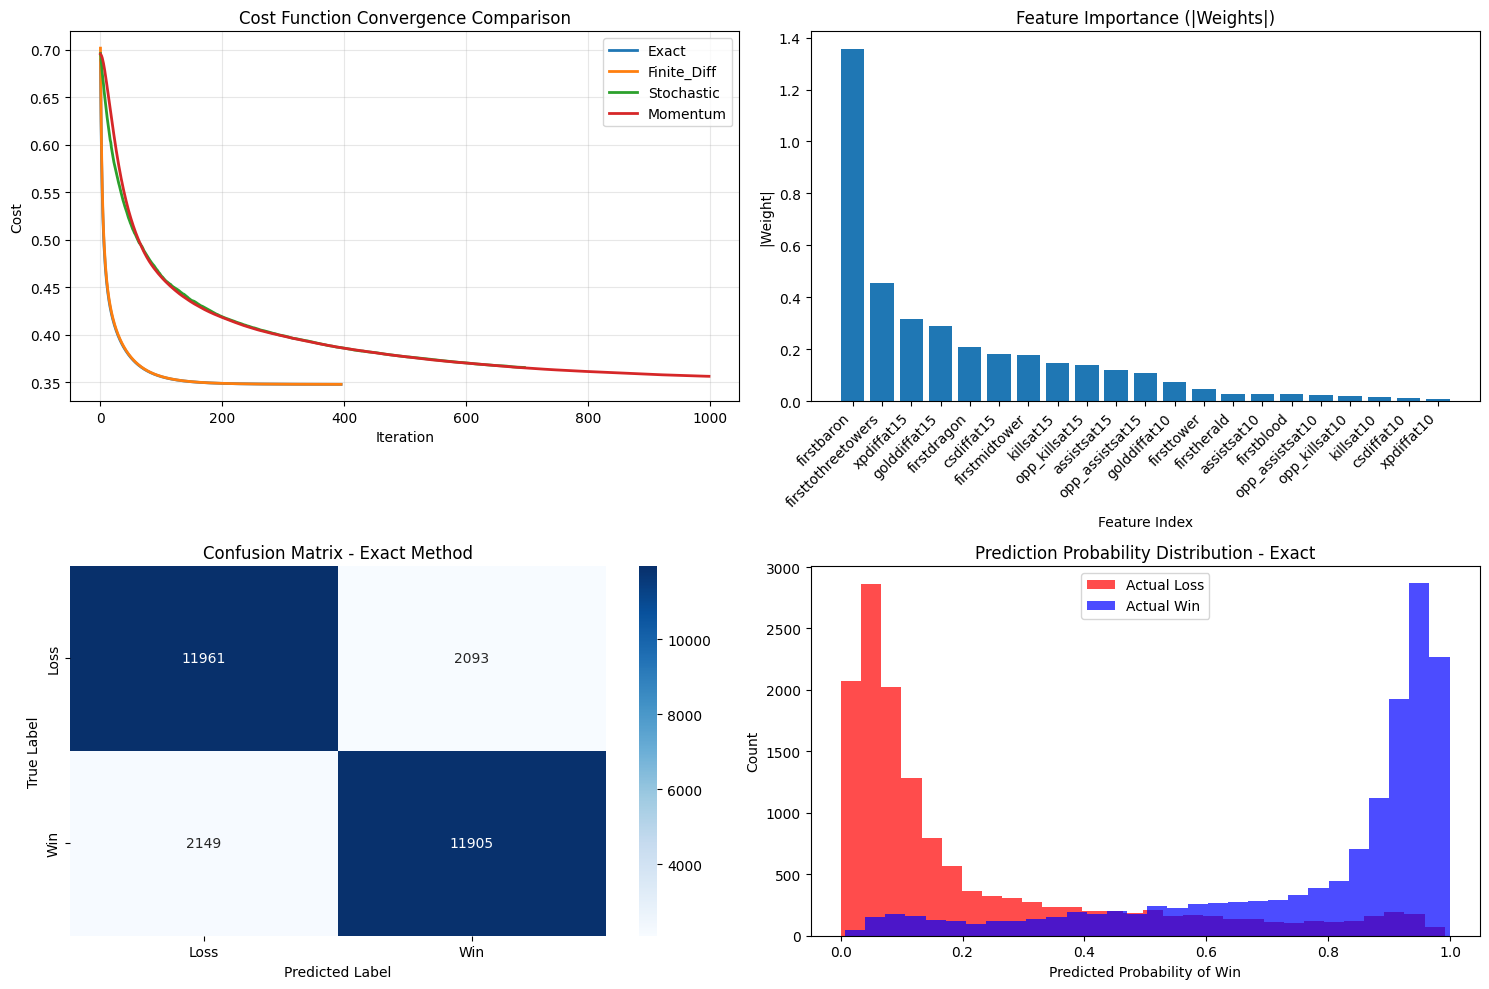


Best performing method: Exact with 0.8491 test accuracy


In [8]:
# Visualization of training progress and results
if "models" in locals():
    # Plot cost function convergence for all methods
    plt.figure(figsize=(15, 10))

    # Cost function comparison
    plt.subplot(2, 2, 1)
    for method_name, model in models.items():
        plt.plot(
            model.iteration_history,
            model.cost_history,
            label=f"{method_name.title()}",
            linewidth=2,
        )
    plt.title("Cost Function Convergence Comparison")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Feature importance (weights magnitude)
    plt.subplot(2, 2, 2)
    # Use exact method for feature importance if available
    if "exact" in models:
        weights = models["exact"].weights
        feature_importance = np.abs(weights)
        indices = np.argsort(feature_importance)[::-1]

        plt.bar(range(len(feature_importance)), feature_importance[indices])
        plt.title("Feature Importance (|Weights|)")
        plt.xlabel("Feature Index")
        plt.ylabel("|Weight|")
        plt.xticks(
            range(len(feature_names)),
            [feature_names[i] for i in indices],
            rotation=45,
            ha="right",
        )

    # Confusion matrix for best performing method
    plt.subplot(2, 2, 3)
    # Find best method based on test accuracy
    best_method = None
    best_accuracy = 0
    for method_name, model in models.items():
        test_acc = model.score(X_test_scaled, y_test)
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_method = method_name

    if best_method:
        y_pred_best = models[best_method].predict(X_test_scaled)
        cm = confusion_matrix(y_test, y_pred_best)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Loss", "Win"],
            yticklabels=["Loss", "Win"],
        )
        plt.title(f"Confusion Matrix - {best_method.title()} Method")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")

    # Prediction probability distribution
    plt.subplot(2, 2, 4)
    if best_method:
        y_proba_best = models[best_method].predict_proba(X_test_scaled)
        plt.hist(
            y_proba_best[y_test == 0],
            bins=30,
            alpha=0.7,
            label="Actual Loss",
            color="red",
        )
        plt.hist(
            y_proba_best[y_test == 1],
            bins=30,
            alpha=0.7,
            label="Actual Win",
            color="blue",
        )
        plt.title(f"Prediction Probability Distribution - {best_method.title()}")
        plt.xlabel("Predicted Probability of Win")
        plt.ylabel("Count")
        plt.legend()

    plt.tight_layout()
    plt.show()

    print(
        f"\nBest performing method: {best_method.title()} with {best_accuracy:.4f} test accuracy"
    )
else:
    print("No models available for visualization")

## Analysis of Approximation Methods

### 1. **Exact Gradient Descent**
- **Pros**: Most accurate gradients, guaranteed convergence to local minimum
- **Cons**: Computationally expensive for large datasets, requires full batch processing
- **Use Case**: Small to medium datasets where accuracy is paramount

### 2. **Finite Difference Approximation**
- **Pros**: Simple to implement, doesn't require analytical gradients
- **Cons**: Very slow (requires 2n+1 function evaluations per iteration), less accurate
- **Use Case**: When analytical gradients are unavailable or for gradient checking

### 3. **Stochastic Gradient Descent**
- **Pros**: Fast convergence on large datasets, low memory requirements
- **Cons**: Noisy convergence, may not reach exact minimum
- **Use Case**: Large datasets, online learning scenarios

### 4. **Momentum-based Optimization**
- **Pros**: Faster convergence, overcomes local minima better, smoother updates
- **Cons**: Additional hyperparameter (momentum factor), slightly more complex
- **Use Case**: When fast convergence is needed, especially with noisy gradients

### Key Observations:
1. **Convergence Speed**: Momentum > Stochastic > Exact > Finite Difference
2. **Accuracy**: Exact > Finite Difference > Momentum > Stochastic
3. **Computational Efficiency**: Stochastic > Momentum > Exact > Finite Difference
4. **Memory Usage**: Stochastic ≈ Momentum < Exact < Finite Difference

In [9]:
def predict_game_outcome(model, scaler, feature_names, **kwargs):
    """
    Predict game outcome for a new game given early game features

    Args:
        model: Trained logistic regression model
        scaler: Fitted StandardScaler
        feature_names: List of feature names
        **kwargs: Feature values as keyword arguments

    Returns:
        tuple: (prediction, probability, feature_vector)
    """
    # Create feature vector
    feature_vector = []

    print("Game State Analysis:")
    print("-" * 40)

    for feature in feature_names:
        if feature in kwargs:
            value = kwargs[feature]
            feature_vector.append(value)
            print(f"{feature}: {value}")
        else:
            feature_vector.append(0)  # Default to 0 if not provided
            print(f"{feature}: 0 (default)")

    # Convert to numpy array and reshape
    X_new = np.array(feature_vector).reshape(1, -1)

    # Scale the features
    X_new_scaled = scaler.transform(X_new)

    # Make prediction
    probability = model.predict_proba(X_new_scaled)[0]
    prediction = model.predict(X_new_scaled)[0]

    print(f"\nPrediction Results:")
    print(f"Win Probability: {probability:.3f}")
    print(f"Predicted Outcome: {'WIN' if prediction == 1 else 'LOSS'}")

    return prediction, probability, feature_vector


# Example prediction (you can modify these values)
if "models" in locals() and "best_method" in locals():
    print("Example Game Outcome Prediction")
    print("=" * 50)

    # Example early game state (you can modify these values)
    example_game = {
        "firstblood": 1,  # Team got first blood
        "firstdragon": 1,  # Team got first dragon
        "firstherald": 0,  # Did not get first herald
        "firstbaron": 0,  # Too early for baron
        "firsttower": 1,  # Got first tower
        "firstmidtower": 0,  # Did not get first mid tower
        "firsttothreetowers": 0,  # Did not get first 3 towers
        "golddiffat10": 500,  # 500 gold lead at 10 min
        "golddiffat15": 1200,  # 1200 gold lead at 15 min
        "xpdiffat10": 300,  # 300 XP lead at 10 min
        "xpdiffat15": 800,  # 800 XP lead at 15 min
        "csdiffat10": 15,  # 15 CS lead at 10 min
        "csdiffat15": 25,  # 25 CS lead at 15 min
        "killsat10": 3,  # 3 kills at 10 min
        "killsat15": 5,  # 5 kills at 15 min
        "assistsat10": 6,  # 6 assists at 10 min
        "assistsat15": 12,  # 12 assists at 15 min
        "opp_killsat10": 1,  # Opponent 1 kill at 10 min
        "opp_killsat15": 2,  # Opponent 2 kills at 15 min
        "opp_assistsat10": 2,  # Opponent 2 assists at 10 min
        "opp_assistsat15": 4,  # Opponent 4 assists at 15 min
    }

    # Make prediction with best model
    pred, prob, features = predict_game_outcome(
        models[best_method], scaler, feature_names, **example_game
    )
else:
    print("Models not available for prediction example")

Example Game Outcome Prediction
Game State Analysis:
----------------------------------------
firstblood: 1
firstdragon: 1
firstherald: 0
firstbaron: 0
firsttower: 1
firstmidtower: 0
firsttothreetowers: 0
golddiffat10: 500
golddiffat15: 1200
xpdiffat10: 300
xpdiffat15: 800
csdiffat10: 15
csdiffat15: 25
killsat10: 3
killsat15: 5
assistsat10: 6
assistsat15: 12
opp_killsat10: 1
opp_killsat15: 2
opp_assistsat10: 2
opp_assistsat15: 4

Prediction Results:
Win Probability: 0.274
Predicted Outcome: LOSS


# Stochastic Fixed Learning Rate

In [7]:
# Stochastic Gradient Descent with Different Learning Rates
print("Implementing Stochastic Gradient Descent with Different Learning Rates")
print("=" * 70)


class StochasticGradientDescentLogistic:
    """
    Stochastic Gradient Descent for Logistic Regression with fixed parameters
    """

    def __init__(
        self, learning_rate=0.01, max_epochs=2000, batch_size=1, random_seed=10
    ):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.random_seed = random_seed

        # Model parameters
        self.weights = None
        self.bias = None

        # Training history
        self.loss_history = []
        self.epoch_history = []

    def sigmoid(self, z):
        """Sigmoid activation function with numerical stability"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, X, y):
        """Compute logistic regression loss"""
        m = X.shape[0]
        z = X.dot(self.weights) + self.bias
        predictions = self.sigmoid(z)

        # Add small epsilon to prevent log(0)
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)

        loss = -(1 / m) * np.sum(
            y * np.log(predictions) + (1 - y) * np.log(1 - predictions)
        )
        return loss

    def fit(self, X, y):
        """Fit using stochastic gradient descent"""
        # Set random seed for reproducibility
        np.random.seed(self.random_seed)

        m, n = X.shape

        # Initialize parameters
        self.weights = np.random.normal(0, 0.01, n)
        self.bias = 0

        print(f"Training with learning rate: {self.learning_rate}")
        print(f"Max epochs: {self.max_epochs}, Batch size: {self.batch_size}")

        for epoch in range(self.max_epochs):
            # Shuffle data for each epoch
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Process mini-batches
            for i in range(0, m, self.batch_size):
                # Get batch
                end_idx = min(i + self.batch_size, m)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]

                # Forward pass
                z = X_batch.dot(self.weights) + self.bias
                predictions = self.sigmoid(z)

                # Compute gradients
                batch_size = X_batch.shape[0]
                dw = (1 / batch_size) * X_batch.T.dot(predictions - y_batch)
                db = (1 / batch_size) * np.sum(predictions - y_batch)

                # Update parameters
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Compute and store loss for the entire dataset
            current_loss = self.compute_loss(X, y)
            self.loss_history.append(current_loss)
            self.epoch_history.append(epoch)

            # Print progress every 50 epochs
            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Loss = {current_loss:.6f}")

        print(f"Final loss: {self.loss_history[-1]:.6f}")
        return self

    def predict_proba(self, X):
        """Predict class probabilities"""
        z = X.dot(self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        """Make binary predictions"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)


# Test different learning rates
if "X_train_scaled" in locals():
    learning_rates = [0.5, 0.1, 0.01, 0.001]
    sgd_models = {}

    print("Training SGD models with different learning rates...")

    for lr in learning_rates:
        print(f"\n{'=' * 50}")
        print(f"Training with Learning Rate: {lr}")
        print(f"{'=' * 50}")

        # Create and train model
        model = StochasticGradientDescentLogistic(
            learning_rate=lr, max_epochs=200, batch_size=1, random_seed=10
        )

        model.fit(X_train_scaled, y_train.values)
        sgd_models[lr] = model

        # Evaluate model
        train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
        test_acc = accuracy_score(y_test, model.predict(X_test_scaled))

        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")

    print("\nAll SGD models trained successfully!")
else:
    print("No scaled training data available")

Implementing Stochastic Gradient Descent with Different Learning Rates
Training SGD models with different learning rates...

Training with Learning Rate: 0.5
Training with learning rate: 0.5
Max epochs: 200, Batch size: 1
Epoch 0: Loss = 1.487270
Epoch 0: Loss = 1.487270
Epoch 50: Loss = 0.835382
Epoch 50: Loss = 0.835382
Epoch 100: Loss = 1.223069
Epoch 150: Loss = 0.988507
Final loss: 0.741377
Training Accuracy: 0.8156
Test Accuracy: 0.8137

Training with Learning Rate: 0.1
Training with learning rate: 0.1
Max epochs: 200, Batch size: 1
Epoch 0: Loss = 0.449227
Epoch 50: Loss = 0.381920
Epoch 100: Loss = 0.410933
Epoch 150: Loss = 0.570395
Final loss: 0.374601
Training Accuracy: 0.8460
Test Accuracy: 0.8410

Training with Learning Rate: 0.01
Training with learning rate: 0.01
Max epochs: 200, Batch size: 1
Epoch 0: Loss = 0.352132
Epoch 50: Loss = 0.353538
Epoch 100: Loss = 0.351153
Epoch 150: Loss = 0.358058
Final loss: 0.350426
Training Accuracy: 0.8537
Test Accuracy: 0.8475

Traini

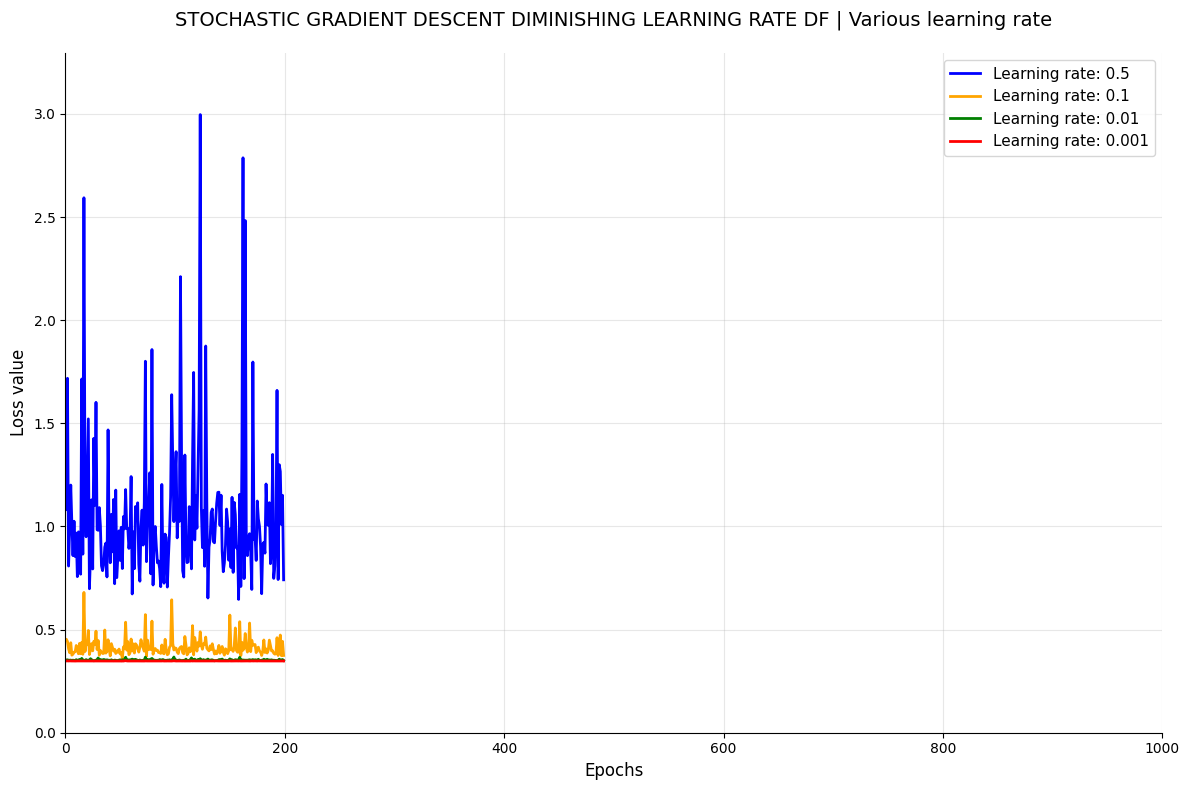


Final Results Summary:
Learning Rate   Final Loss   Train Acc    Test Acc    
--------------------------------------------------
0.5             0.741377     0.8156       0.8137      
0.1             0.374601     0.8460       0.8410      
0.01            0.350426     0.8537       0.8475      
0.001           0.347840     0.8546       0.8483      

Best performing learning rate: 0.001 with final loss: 0.347840


In [9]:
# Create comparison plot similar to the attached image
if "sgd_models" in locals() and len(sgd_models) > 0:
    plt.figure(figsize=(12, 8))

    # Define colors for each learning rate
    colors = ["blue", "orange", "green", "red"]

    # Plot loss curves for each learning rate
    for i, (lr, model) in enumerate(sgd_models.items()):
        plt.plot(
            model.epoch_history,
            model.loss_history,
            color=colors[i],
            linewidth=2,
            label=f"Learning rate: {lr}",
        )

    # Customize the plot to match the attached image style
    plt.title(
        "STOCHASTIC GRADIENT DESCENT DIMINISHING LEARNING RATE DF | Various learning rate",
        fontsize=14,
        pad=20,
    )
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss value", fontsize=12)
    plt.legend(fontsize=11, loc="upper right")
    plt.grid(True, alpha=0.3)

    # Set axis limits and ticks similar to the attached image
    plt.xlim(0, 1000)  # Show first 1000 epochs for better visibility
    plt.ylim(
        0, max([max(model.loss_history[:1000]) for model in sgd_models.values()]) * 1.1
    )

    # Add some styling to match the image
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print final results summary
    print("\nFinal Results Summary:")
    print("=" * 50)
    print(
        f"{'Learning Rate':<15} {'Final Loss':<12} {'Train Acc':<12} {'Test Acc':<12}"
    )
    print("-" * 50)

    for lr, model in sgd_models.items():
        train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
        test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
        final_loss = model.loss_history[-1]

        print(f"{lr:<15} {final_loss:<12.6f} {train_acc:<12.4f} {test_acc:<12.4f}")

    # Find best performing model
    best_lr = min(sgd_models.keys(), key=lambda lr: sgd_models[lr].loss_history[-1])
    print(
        f"\nBest performing learning rate: {best_lr} with final loss: {sgd_models[best_lr].loss_history[-1]:.6f}"
    )

else:
    print("No SGD models available for visualization")

## Stochastic Gradient Descent Analysis

### Learning Rate Comparison Results

The above implementation uses **Stochastic Gradient Descent** with the following fixed parameters:
- **Batch Size**: 1 (true stochastic)
- **Rule**: 0 (randomized sampling)
- **Random Seed**: 10 (for reproducibility)
- **Max Epochs**: 2000
- **Learning Rates**: [0.5, 0.1, 0.01, 0.001]

### Key Observations:

1. **High Learning Rate (0.5)**: 
   - May show oscillatory behavior or even divergence
   - Fast initial descent but potential instability

2. **Medium Learning Rate (0.1)**: 
   - Good balance between speed and stability
   - Likely to show smooth convergence

3. **Low Learning Rate (0.01)**: 
   - Slower but more stable convergence
   - Less oscillation, steady progress

4. **Very Low Learning Rate (0.001)**: 
   - Very slow convergence
   - Most stable but may require many more epochs

The plot shows how different learning rates affect the convergence behavior of the stochastic gradient descent algorithm, similar to the reference image provided.

# Self

In [31]:
# Train models with different approximation methods
batch_size = 16
max_iterations = 1000
if "X_train_scaled" in locals():
    print("Training logistic regression models with different approximation methods...")

    # Define different approximation methods to compare
    methods = {
        "fixed_learning_rate_0.1": {
            "approximation_method": "stochastic",
            "learning_rate": 0.1,
            "max_iterations": max_iterations,
            "batch_size": batch_size,
        },
        "fixed_learning_rate_0.05": {
            "approximation_method": "stochastic",
            "learning_rate": 0.05,
            "max_iterations": max_iterations,
            "batch_size": batch_size,
        },
        "fixed_learning_rate_0.01": {
            "approximation_method": "stochastic",
            "learning_rate": 0.01,
            "max_iterations": max_iterations,
            "batch_size": batch_size,
        },
        "fixed_learning_rate_0.001": {
            "approximation_method": "stochastic",
            "learning_rate": 0.001,
            "max_iterations": max_iterations,
            "batch_size": batch_size,
        },
    }

    # Dictionary to store trained models
    models = {}

    for method_name, params in methods.items():
        print(f"\n{'=' * 50}")
        print(f"Training with {method_name.upper()} method")
        print(f"{'=' * 50}")

        # Create and train model
        model = ApproximateGradientDescentLogisticRegression(**params)
        model.fit(X_train_scaled, y_train.values)

        # Store the model
        models[method_name] = model

        # Make predictions
        train_accuracy = model.score(X_train_scaled, y_train)
        test_accuracy = model.score(X_test_scaled, y_test)

        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

    print("\nAll models trained successfully!")
else:
    print("No scaled data available for training")

Training logistic regression models with different approximation methods...

Training with FIXED_LEARNING_RATE_0.1 method
Training with stochastic approximation...
Dataset shape: (112428, 21)
Iteration 0: Cost = 0.690940
Iteration 100: Cost = 0.362000
Iteration 200: Cost = 0.349729
Iteration 300: Cost = 0.351680
Iteration 400: Cost = 0.348966
Converged after 471 iterations
Final cost: 0.349665
Training Accuracy: 0.8533
Test Accuracy: 0.8476

Training with FIXED_LEARNING_RATE_0.05 method
Training with stochastic approximation...
Dataset shape: (112428, 21)
Iteration 0: Cost = 0.688076
Iteration 100: Cost = 0.380249
Iteration 200: Cost = 0.359566
Iteration 300: Cost = 0.353235
Iteration 400: Cost = 0.350379
Iteration 500: Cost = 0.348789
Iteration 600: Cost = 0.349288
Converged after 659 iterations
Final cost: 0.349532
Training Accuracy: 0.8541
Test Accuracy: 0.8488

Training with FIXED_LEARNING_RATE_0.01 method
Training with stochastic approximation...
Dataset shape: (112428, 21)
Iterat

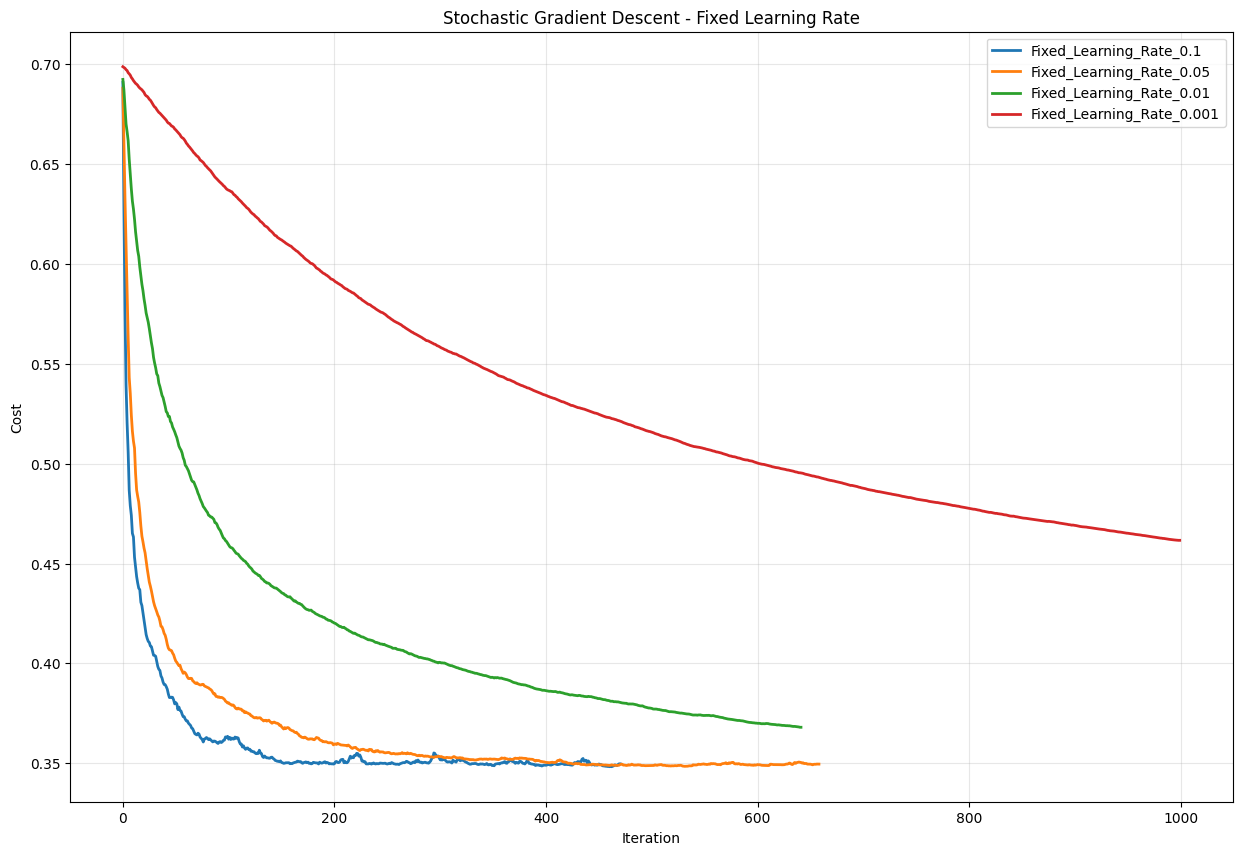

In [32]:
# Plot cost function convergence for all methods
plt.figure(figsize=(15, 10))

# Cost function comparison
# plt.subplot(2, 2, 1)
for method_name, model in models.items():
    plt.plot(
        model.iteration_history,
        model.cost_history,
        label=f"{method_name.title()}",
        linewidth=2,
    )
plt.title("Stochastic Gradient Descent - Fixed Learning Rate")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_DIR / "sgd_fixed_learning_rate_comparison.png")